In [95]:
"""This module prepares the data, splits into train/test, and performs undersampling to balance the data set. 
Then it trains and compares these machine learning models:
- Logistic Regression
- Ridge Classifier
- Random Forest Classifier
- K-Neighbours Classifier
-"""

import sqlite3
import pandas as pd

try:
    database_path = "data/data.db"
    conn = sqlite3.connect(database_path)
    query = open('data/fetch_all.sql', 'r').read()
    df_raw = pd.read_sql_query(query, conn)
except (sqlite3.Error, FileNotFoundError) as e:
    print(f"An error occurred: {e}")
finally:
    if 'conn' in locals():
        conn.close()

# Filter only rows with 'yes' or 'no' in the 'y' column\
df_raw.set_index('client_id', inplace=True)

df = df_raw[df_raw['y'].isin(['no', 'yes'])]

# Isolate the unseen data
df_unseen = df_raw[df_raw['y'] == 'unknown']

# Drop specified columns
df = df.drop(columns=['account_id', 'campaign_id', 'outcome_id', 'previous', 'poutcome', 'month'])
df_unseen = df_unseen.drop(columns=['account_id', 'campaign_id', 'outcome_id', 'previous', 'poutcome', 'month'])

In [96]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

def preprocess_data(df):
    # Binning day of the week into Early, Mid, and Late
    bins = [0, 9, 19, 31]
    labels = ['early', 'mid', 'late']
    df['day_bin'] = pd.cut(df['day'], bins=bins, labels=labels, right=True)

    # Binning age into common bins
    age_bins = [0, 25, 36, 55, 65, 100]
    age_labels = ['<25', '25-35', '36-55', '55-65', '65+']
    df['age_bin'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)

    # Identify numerical and categorical columns
    numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_columns = df.select_dtypes(include=['object']).columns

    # Initialize OneHotEncoder
    encoder = OneHotEncoder(sparse_output=False, drop='first')

    # Fit and transform the categorical columns
    encoded_features = encoder.fit_transform(df[categorical_columns])

    # Create a DataFrame with the encoded features
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))

    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit and transform the numerical columns
    scaled_numeric_features = scaler.fit_transform(df[numerical_columns])

    # Create a DataFrame with the scaled numerical features
    scaled_numeric_df = pd.DataFrame(scaled_numeric_features, columns=numerical_columns)

    # Concatenate the scaled numerical features and the encoded categorical features
    df_enc = pd.concat([scaled_numeric_df, encoded_df], axis=1)

    return df_enc

df_enc = preprocess_data(df)

print(df_enc.head())

        age   balance       day  duration  campaign     pdays  \
0  0.078478 -0.472088 -1.323585  0.446598 -0.576829 -0.407218   
1  0.173040 -0.275697 -1.323585 -0.804230 -0.576829 -0.407218   
2  1.496912 -0.418920 -1.323585 -0.346234 -0.576829 -0.407218   
3  1.496912 -0.193951 -1.323585 -0.149950 -0.576829 -0.407218   
4  1.686036 -0.472753 -1.323585 -0.146102 -0.576829 -0.407218   

   job_blue-collar  job_entrepreneur  job_housemaid  job_management  ...  \
0              0.0               1.0            0.0             0.0  ...   
1              0.0               0.0            0.0             0.0  ...   
2              0.0               0.0            0.0             0.0  ...   
3              0.0               0.0            0.0             0.0  ...   
4              1.0               0.0            0.0             0.0  ...   

   marital_single  education_secondary  education_tertiary  education_unknown  \
0             0.0                  0.0                 1.0             

In [97]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assuming df_encoded_min_max_scaled is the dataframe to be split
X = df_enc.drop(columns=['y_yes'])
y = df_enc['y_yes']

# Apply SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

In [98]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets with 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (6400, 27)
X_test shape: (1600, 27)
y_train shape: (6400,)
y_test shape: (1600,)


Model: Logistic Regression
Best Parameters: {'C': 0.1, 'solver': 'liblinear'}
Cross-Validation Score: 0.8087499999999999
Test Accuracy: 0.8
Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.80      0.80       803
         1.0       0.80      0.80      0.80       797

    accuracy                           0.80      1600
   macro avg       0.80      0.80      0.80      1600
weighted avg       0.80      0.80      0.80      1600



Model: Ridge Classifier
Best Parameters: N/A (RidgeClassifierCV performs internal CV)
Cross-Validation Score: 0.8021875
Test Accuracy: 0.79
Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.79      0.79       803
         1.0       0.79      0.79      0.79       797

    accuracy                           0.79      1600
   macro avg       0.79      0.79      0.79      1600
weighted avg       0.79      0.79      0.79      1600



Model: Random Fo

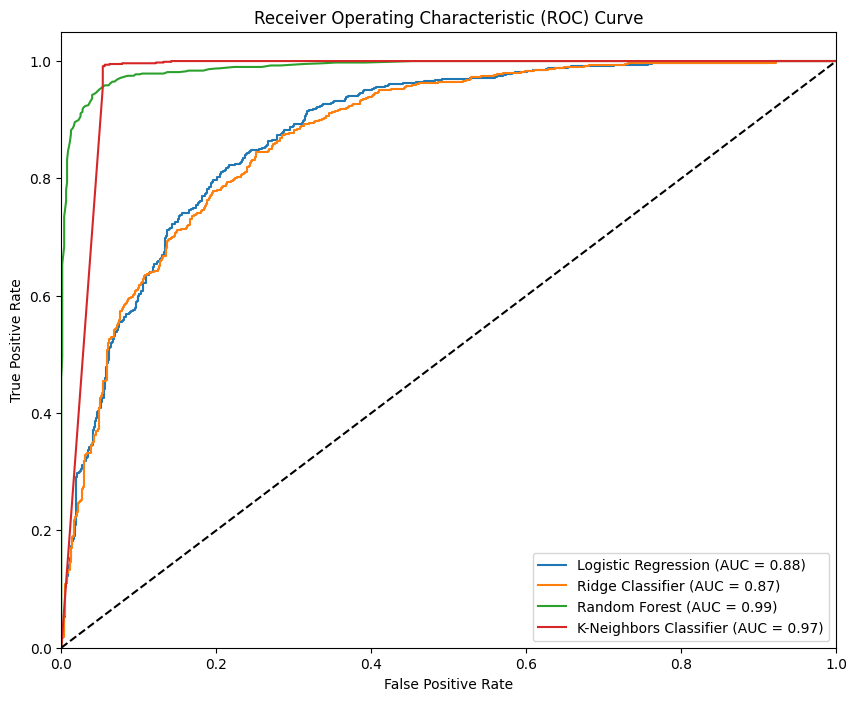

In [99]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold


# Define the models and their hyperparameters
models = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {
            'C': [0.1, 1, 10],
            'solver': ['liblinear']
        }
    },
    'Ridge Classifier': {
        'model': RidgeClassifierCV(alphas=[0.1, 1.0, 10.0], cv=5),
        'params': {}
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    },
    'K-Neighbors Classifier': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    }
}

# Initialize StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and hyperparameter tuning
results = []
roc_data = {}
for model_name, model_info in models.items():
    if model_name == 'Ridge Classifier':
        clf = model_info['model']
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_pred_proba = clf.decision_function(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        roc_data[model_name] = (y_test, y_pred_proba)
        results.append({
            'Model': model_name,
            'Best Parameters': 'N/A (RidgeClassifierCV performs internal CV)',
            'Cross-Validation Score': clf.score(X_train, y_train),
            'Test Accuracy': accuracy,
            'Classification Report': classification_report(y_test, y_pred)
        })
    else:
        clf = GridSearchCV(model_info['model'], model_info['params'], cv=kf, scoring='accuracy')
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_pred_proba = clf.predict_proba(X_test)[:, 1]
        accuracy = accuracy_score(y_test, y_pred)
        roc_data[model_name] = (y_test, y_pred_proba)
        results.append({
            'Model': model_name,
            'Best Parameters': clf.best_params_,
            'Cross-Validation Score': clf.best_score_,
            'Test Accuracy': accuracy,
            'Classification Report': classification_report(y_test, y_pred)
        })

# Display the results
for result in results:
    print(f"Model: {result['Model']}")
    print(f"Best Parameters: {result['Best Parameters']}")
    print(f"Cross-Validation Score: {result['Cross-Validation Score']}")
    print(f"Test Accuracy: {result['Test Accuracy']}")
    print(f"Classification Report:\n{result['Classification Report']}")
    print("\n" + "="*80 + "\n")

# Plot ROC curves
plt.figure(figsize=(10, 8))
for model_name, (y_test, y_pred_proba) in roc_data.items():
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [103]:
# Train the Random Forest model with the best parameters
best_rf_model = RandomForestClassifier(max_depth=None, min_samples_split=2, n_estimators=100, random_state=42)
best_rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [104]:
print(df_unseen.head())
print(df_unseen.shape)

df_unseen_enc = preprocess_data(df_unseen)

           age           job  marital  education in_default  balance housing  \
client_id                                                                      
4815378     58    management  married   tertiary         no   2143.0     yes   
5217541     44    technician   single  secondary         no     29.0     yes   
6654642     33  entrepreneur  married  secondary         no      2.0     yes   
1421898     47   blue-collar  married    unknown         no   1506.0     yes   
2387933     33       unknown   single    unknown         no      1.0      no   

          loan  contact  day  duration  campaign  pdays        y day_bin  \
client_id                                                                  
4815378     no  unknown    5       261         1     -1  unknown   early   
5217541     no  unknown    5       151         1     -1  unknown   early   
6654642    yes  unknown    5        76         1     -1  unknown   early   
1421898     no  unknown    5        92         1     -1  un

In [107]:
import csv

# Predict probabilities for the unseen data
y_unseen_pred_proba = best_rf_model.predict_proba(df_unseen_enc)[:, 1]

# Set a threshold to classify as 'yes'
threshold = 0.5
y_unseen_pred = (y_unseen_pred_proba >= threshold).astype(int)

# Get the client_ids where the prediction is 'yes'
client_ids_yes = df_unseen.index[y_unseen_pred == 1].tolist()

# Save client_ids_yes to a CSV file
with open('client_ids_yes.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['client_id'])
    writer.writerows([[client_id] for client_id in client_ids_yes])

print(client_ids_yes)

[9030024, 3746685, 6056906, 2717329, 3834637, 3838239, 3410461, 8719827, 6566665, 3316223, 7458388, 8158345, 8379299, 3694492, 9904722, 1087198, 1331953, 8434306, 9270546, 2546148, 2379755, 4939192, 2972390, 1590562, 4024690, 1216397, 7170052, 6855358, 9469530, 9221832, 4050995, 1082447, 4453595, 5627516, 8922116, 9119007, 2061109, 9364319, 7546443, 2485151, 6817827, 5509000, 6596195, 5163091, 4176005, 4763766, 8991814, 5276105, 9167322, 4326490, 4134957, 7595483, 1461661, 2989216, 6007572, 8558939, 6089493, 6603548, 6736039, 6457988, 4622302, 9269604, 5830810, 4357477, 3225864, 8788853, 8031318, 2047663, 4107663, 1521648, 4687739, 8970781, 8827642, 8559789, 5142441, 8197063, 1768358, 2479777, 3357525, 2970046, 4019537, 4853170, 4868149, 4657921, 3657761, 4926256, 5269862, 6370783, 8173604, 7615667, 5298978, 4576037, 6839973, 8532425, 4274723, 7229770, 1005032, 7730359, 7252338, 4635664, 6690873, 1796404, 9007822, 8156633, 8277692, 6774173, 3741025, 5225887, 1532536, 3136909, 6454102, 

In [109]:
print(len(client_ids_yes))
print(type(client_ids_yes))
print(type(client_ids_yes[0]))

8338
<class 'list'>
<class 'int'>
